In [1]:
import pandas as pd
import numpy as np
import nltk
from collections import Counter
from textblob import TextBlob
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from wordcloud import WordCloud, ImageColorGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import re, string, unicodedata
import inflect
import ast
import re
import json

In [2]:
# remove URLS, numbers

def remove_URL(sample):
    """Remove URLs from a sample string"""
    new_words = []
    for word in sample:
        if (re.sub(r"http\S+", "", word) != ''):
            new_words.append(word)
    return new_words

def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words


def replace_numbers(words):
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    p = inflect.engine()
    new_words = []
    for word in words:
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return new_words



def clean_text(tokens):
    new_words = []
    stop_words = ['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could', '_', 'be', 'know', 'good', 
                    'get', 'do', 'done', 'try', 'many', 'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily',
                   'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right', 'line', 'even', 'also', 'may',
                   'take', 'come','amp','http','https','width', 'autowebp','formatpng','&','fuck']

    emoji_pat = '[\U0001F300-\U0001F64F\U0001F680-\U0001F6FF\u2600-\u26FF\u2700-\u27BF]'
    shrink_whitespace_reg = re.compile(r'\s{2,}')
    for word in tokens:
      reg = re.compile(r'({})|[^a-zA-Z]'.format(emoji_pat)) # line a
      result = reg.sub(lambda x: ' {} '.format(x.group(1)) if x.group(1) else '', word)
      if(result != '' and result not in stop_words):
        new_words.append(shrink_whitespace_reg.sub(' ', result))
    return new_words

In [3]:
df_NLP = pd.read_csv('/content/drive/MyDrive/WSB/wsb_submissions_NLP_clean.csv')
df_features = pd.read_csv('/content/drive/MyDrive/WSB/WSB_submissions_with_sentiment.csv',sep=';')

In [4]:
#get link_flair_text,	num_comments,	score,upvote_ratio
df_NLP = pd.merge(df_NLP,df_features[['id','link_flair_text',	'num_comments',	'score','upvote_ratio']],on='id',how='left')

In [5]:
df_NLP.drop('Unnamed: 0',inplace=True,axis=1)

In [6]:
df_NLP.head()

created_utc      id  ... score upvote_ratio
0  2021-10-19 17:58:57  qbh10s  ...     1          1.0
1  2021-10-19 17:57:49  qbh04w  ...     1          1.0
2  2021-10-19 17:55:24  qbgyco  ...     1          1.0
3  2021-10-19 17:54:51  qbgxy8  ...     1          1.0
4  2021-10-19 17:52:33  qbgw9u  ...     1          1.0

[5 rows x 10 columns]

In [8]:
test = df_NLP.loc[:10,'title_lemmatized'].apply(lambda s: clean_text(list(ast.literal_eval(s))))
test = df_NLP.loc[:10,'selftext_lemmatized'].apply(lambda s: clean_text(list(ast.literal_eval(s))))
test

0     [cad, bb, move, gain, traction, ape, brain, mo...
1                                                    []
2                                                    []
3                                                    []
4     [bb, move, higher, patent, alone, pipeline, ho...
5                                                    []
6                                                    []
7                                                    []
8                                                    []
9     [nerd, long, time, post, bearing, gift, knowle...
10    [tsla, beating, estimate, delivery, earnings, ...
Name: selftext_lemmatized, dtype: object

In [7]:
df_NLP['title_lemmatized'] = df_NLP['title_lemmatized'].apply(lambda s: clean_text(list(ast.literal_eval(s))))
df_NLP['selftext_lemmatized'] = df_NLP['selftext_lemmatized'].apply(lambda s: clean_text(list(ast.literal_eval(s))))

In [10]:
words =  df_NLP['title_lemmatized']
allwords = []
for wordlist in words:
    allwords += wordlist
print(allwords[0:50])


['bb', 'surely', 'coincidence', 'yolo', 'sava', 'option', 'meme', 'bb', 'sdig', 'sit', 'ape', 'strong', 'charging', 'bull', 'inspiration', 'prog', 'yolo', 'yr', 'menace', 'hedge', 'fund', 'squeeze', 'short', 'hood', 'k', 'gain', 'tsla', 'delivery', 'preearnings', 'tpx', 'look', 'one', 'future', 'help', 'bite', 'lol', ' 😂 ', 'something', 'genuis', ' 💎 🏾 ', 'bb', ' 🚀 🚀 🚀 🚀 🚀 ', 'serious', 'question', 'understand', 'amc', 'gme', 'still', 'push', 'others']


In [11]:
words =  df_NLP['selftext_lemmatized']
allwords_selftext = []
for wordlist in words:
    allwords_selftext += wordlist
print(allwords_selftext[0:50])

['cad', 'bb', 'move', 'gain', 'traction', 'ape', 'brain', 'move', 'one', 'late', 'buy', 'black', 'berry', 'move', 'bb', 'move', 'higher', 'patent', 'alone', 'pipeline', 'holder', 'stock', 'strong', 'believer', 'stock', 'year', 'hold', 'tight', 'nerd', 'long', 'time', 'post', 'bearing', 'gift', 'knowledge', 'whatever', 'knowledge', 'the', 'knowledge', 'hood', 'prim', 'massive', 'short', 'squeeze', 'muchtouted', 'wsb', 'metric', 'time', 'exist', 'reality']


In [12]:
type(allwords_selftext)

list

In [13]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(df_NLP['title_lemmatized'])
# Create Corpus
texts = df_NLP['title_lemmatized']
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:2][0][:30])

[(0, 1)]


In [14]:
from pprint import pprint
import gensim
# number of topics
num_topics = 10
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.044*"tsla" + 0.019*"happen" + 0.018*"pump" + 0.017*"trump" + 0.016*"papa" '
  '+ 0.016*"aapl" + 0.014*"confirm" + 0.010*"fed" + 0.009*"airline" + '
  '0.009*"bullish"'),
 (1,
  '0.050*"money" + 0.043*"retard" + 0.040*"one" + 0.027*"lose" + 0.021*"yolo" '
  '+ 0.020*"invest" + 0.012*"meme" + 0.012*"boy" + 0.012*"put" + 0.011*"give"'),
 (2,
  '0.057*"gme" + 0.040*"buy" + 0.027*"gt" + 0.017*"share" + 0.014*"thread" + '
  '0.012*"rh" + 0.012*"daily" + 0.011*"daddy" + 0.010*"prpl" + 0.010*"fund"'),
 (3,
  '0.121*"go" + 0.058*"u" + 0.043*"moon" + 0.037*"hold" + 0.031*"let" + '
  '0.026*" 🚀 " + 0.023*"help" + 0.019*"jpow" + 0.019*" 🌈 🐻 " + 0.016*"work"'),
 (4,
  '0.050*"bear" + 0.029*"trading" + 0.028*"tendies" + 0.025*"bull" + '
  '0.022*"gain" + 0.022*"guy" + 0.016*"gay" + 0.014*"start" + 0.014*"thanks" + '
  '0.013*"loss"'),
 (5,
  '0.042*"robinhood" + 0.025*"anyone" + 0.023*"stonks" + 0.018*"tell" + '
  '0.016*"someone" + 0.012*"advice" + 0.011*"else" + 0.011*"spread" + '
  '0.0

In [8]:
def format_topics_sentences(ldamodel_, corpus_, texts_):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel_[corpus_]):
        row = row_list[0] if ldamodel_.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel_.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts_)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [16]:
df_topic_sents_keywords = format_topics_sentences(ldamodel_=lda_model, corpus_=corpus, texts_=texts)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

Document_No  ...                                         Text
0            0  ...                                         [bb]
1            1  ...                        [surely, coincidence]
2            2  ...                         [yolo, sava, option]
3            3  ...                                       [meme]
4            4  ...                                         [bb]
5            5  ...                                       [sdig]
6            6  ...           [sit, ape, strong, charging, bull]
7            7  ...                                [inspiration]
8            8  ...                             [prog, yolo, yr]
9            9  ...  [menace, hedge, fund, squeeze, short, hood]

[10 rows x 5 columns]

In [17]:
df_dominant_topic.to_csv('/content/drive/MyDrive/WSB/df_dominant_topics_title.csv')

In [19]:
sent_topics_sorteddf_mallet.head()

Document_No  ...                                                                                                 Text
0        63011  ...  [zkin, zkin, zkin, zkin, zkin, zkin, zkin, zkin, zkin, zkin, zkin, zkin, zkin, zkin, zkin, zkin,...
1       487576  ...  [doge, doge, doge, doge, doge, doge, doge, doge, doge, doge, doge, doge, doge, doge, doge, doge,...
2       517045  ...  [amc, amc, amc, amc, amc, amc, amc, amc, amc, amc, amc, amc, amc, amc, amc, amc, amc, amc, amc, ...
3       429922  ...  [hold, hold, hold, hold, hold, hold, hold, hold, hold, hold, hold, hold, hold, hold, hold, hold,...
4       488589  ...  [ag, ag, ag, ag, ag, ag, ag, ag, ag, ag, ag, ag, ag, ag, ag, ag, ag, ag, ag, ag, ag, ag, ag, ag,...

[5 rows x 5 columns]

In [20]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_dominant_topic.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Topic_Perc_Contrib'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Document_No','Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

Document_No  ...                                                                                  Representative Text
0        63011  ...  [zkin, zkin, zkin, zkin, zkin, zkin, zkin, zkin, zkin, zkin, zkin, zkin, zkin, zkin, zkin, zkin,...
1       487576  ...  [doge, doge, doge, doge, doge, doge, doge, doge, doge, doge, doge, doge, doge, doge, doge, doge,...
2       517045  ...  [amc, amc, amc, amc, amc, amc, amc, amc, amc, amc, amc, amc, amc, amc, amc, amc, amc, amc, amc, ...
3       429922  ...  [hold, hold, hold, hold, hold, hold, hold, hold, hold, hold, hold, hold, hold, hold, hold, hold,...
4       488589  ...  [ag, ag, ag, ag, ag, ag, ag, ag, ag, ag, ag, ag, ag, ag, ag, ag, ag, ag, ag, ag, ag, ag, ag, ag,...
5       281140  ...  [cmps,  🌈 ,  🌈 ,  🌈 ,  🌈 ,  🌈 ,  🌈 ,  🌈 ,  🌈 ,  🌈 ,  🌈 ,  🌈 ,  🌈 ,  🌈 ,  🌈 ,  🌈 ,  🌈 ,  🌈 ,  🌈 ,...
6       565281  ...  [blackberry, blackberry, blackberry, blackberry, blackberry, blackberry, blackberry, blackberry,...
7       267250  ...  [red, red, red, red, red, red, red, red, red, red, red, red, red, red, red, red, red, red, red, ...
8       481322  ...                               [buy, dip, buy, dip, buy, dip, buy, dip, buy, dip, buy, dip, buy, dip]
9        20165  ...                    [dick,  🍆 , yes,  🍆 , yes,  🍆 , yes,  🍆 , yes,  🍆 , yes,  🍆 , yes,  🍆 , yes,  🍆 ]

[10 rows x 5 columns]

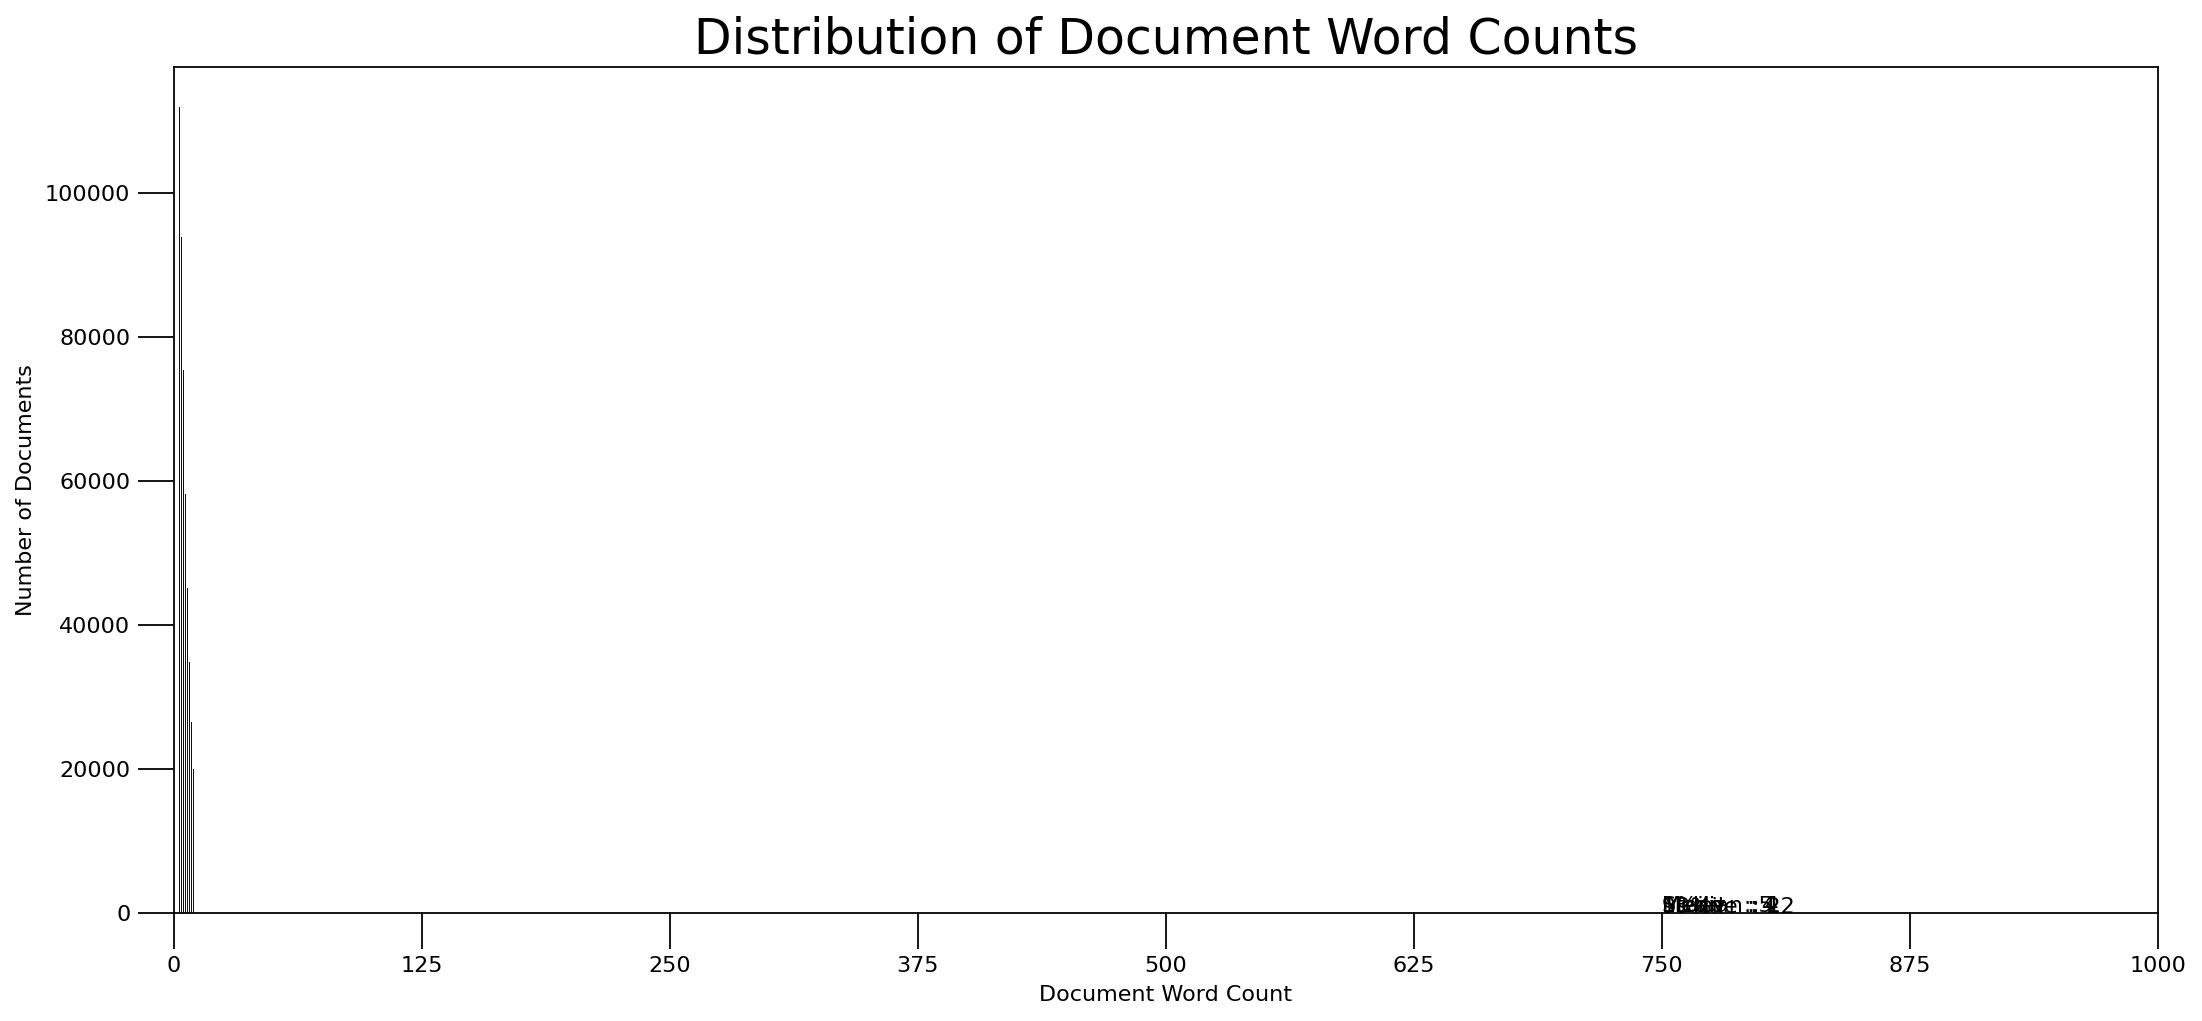

In [21]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 100, color='navy')
plt.text(750, 100, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750,  90, "Median : " + str(round(np.median(doc_lens))))
plt.text(750,  80, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750,  70, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750,  60, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 100), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,100,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

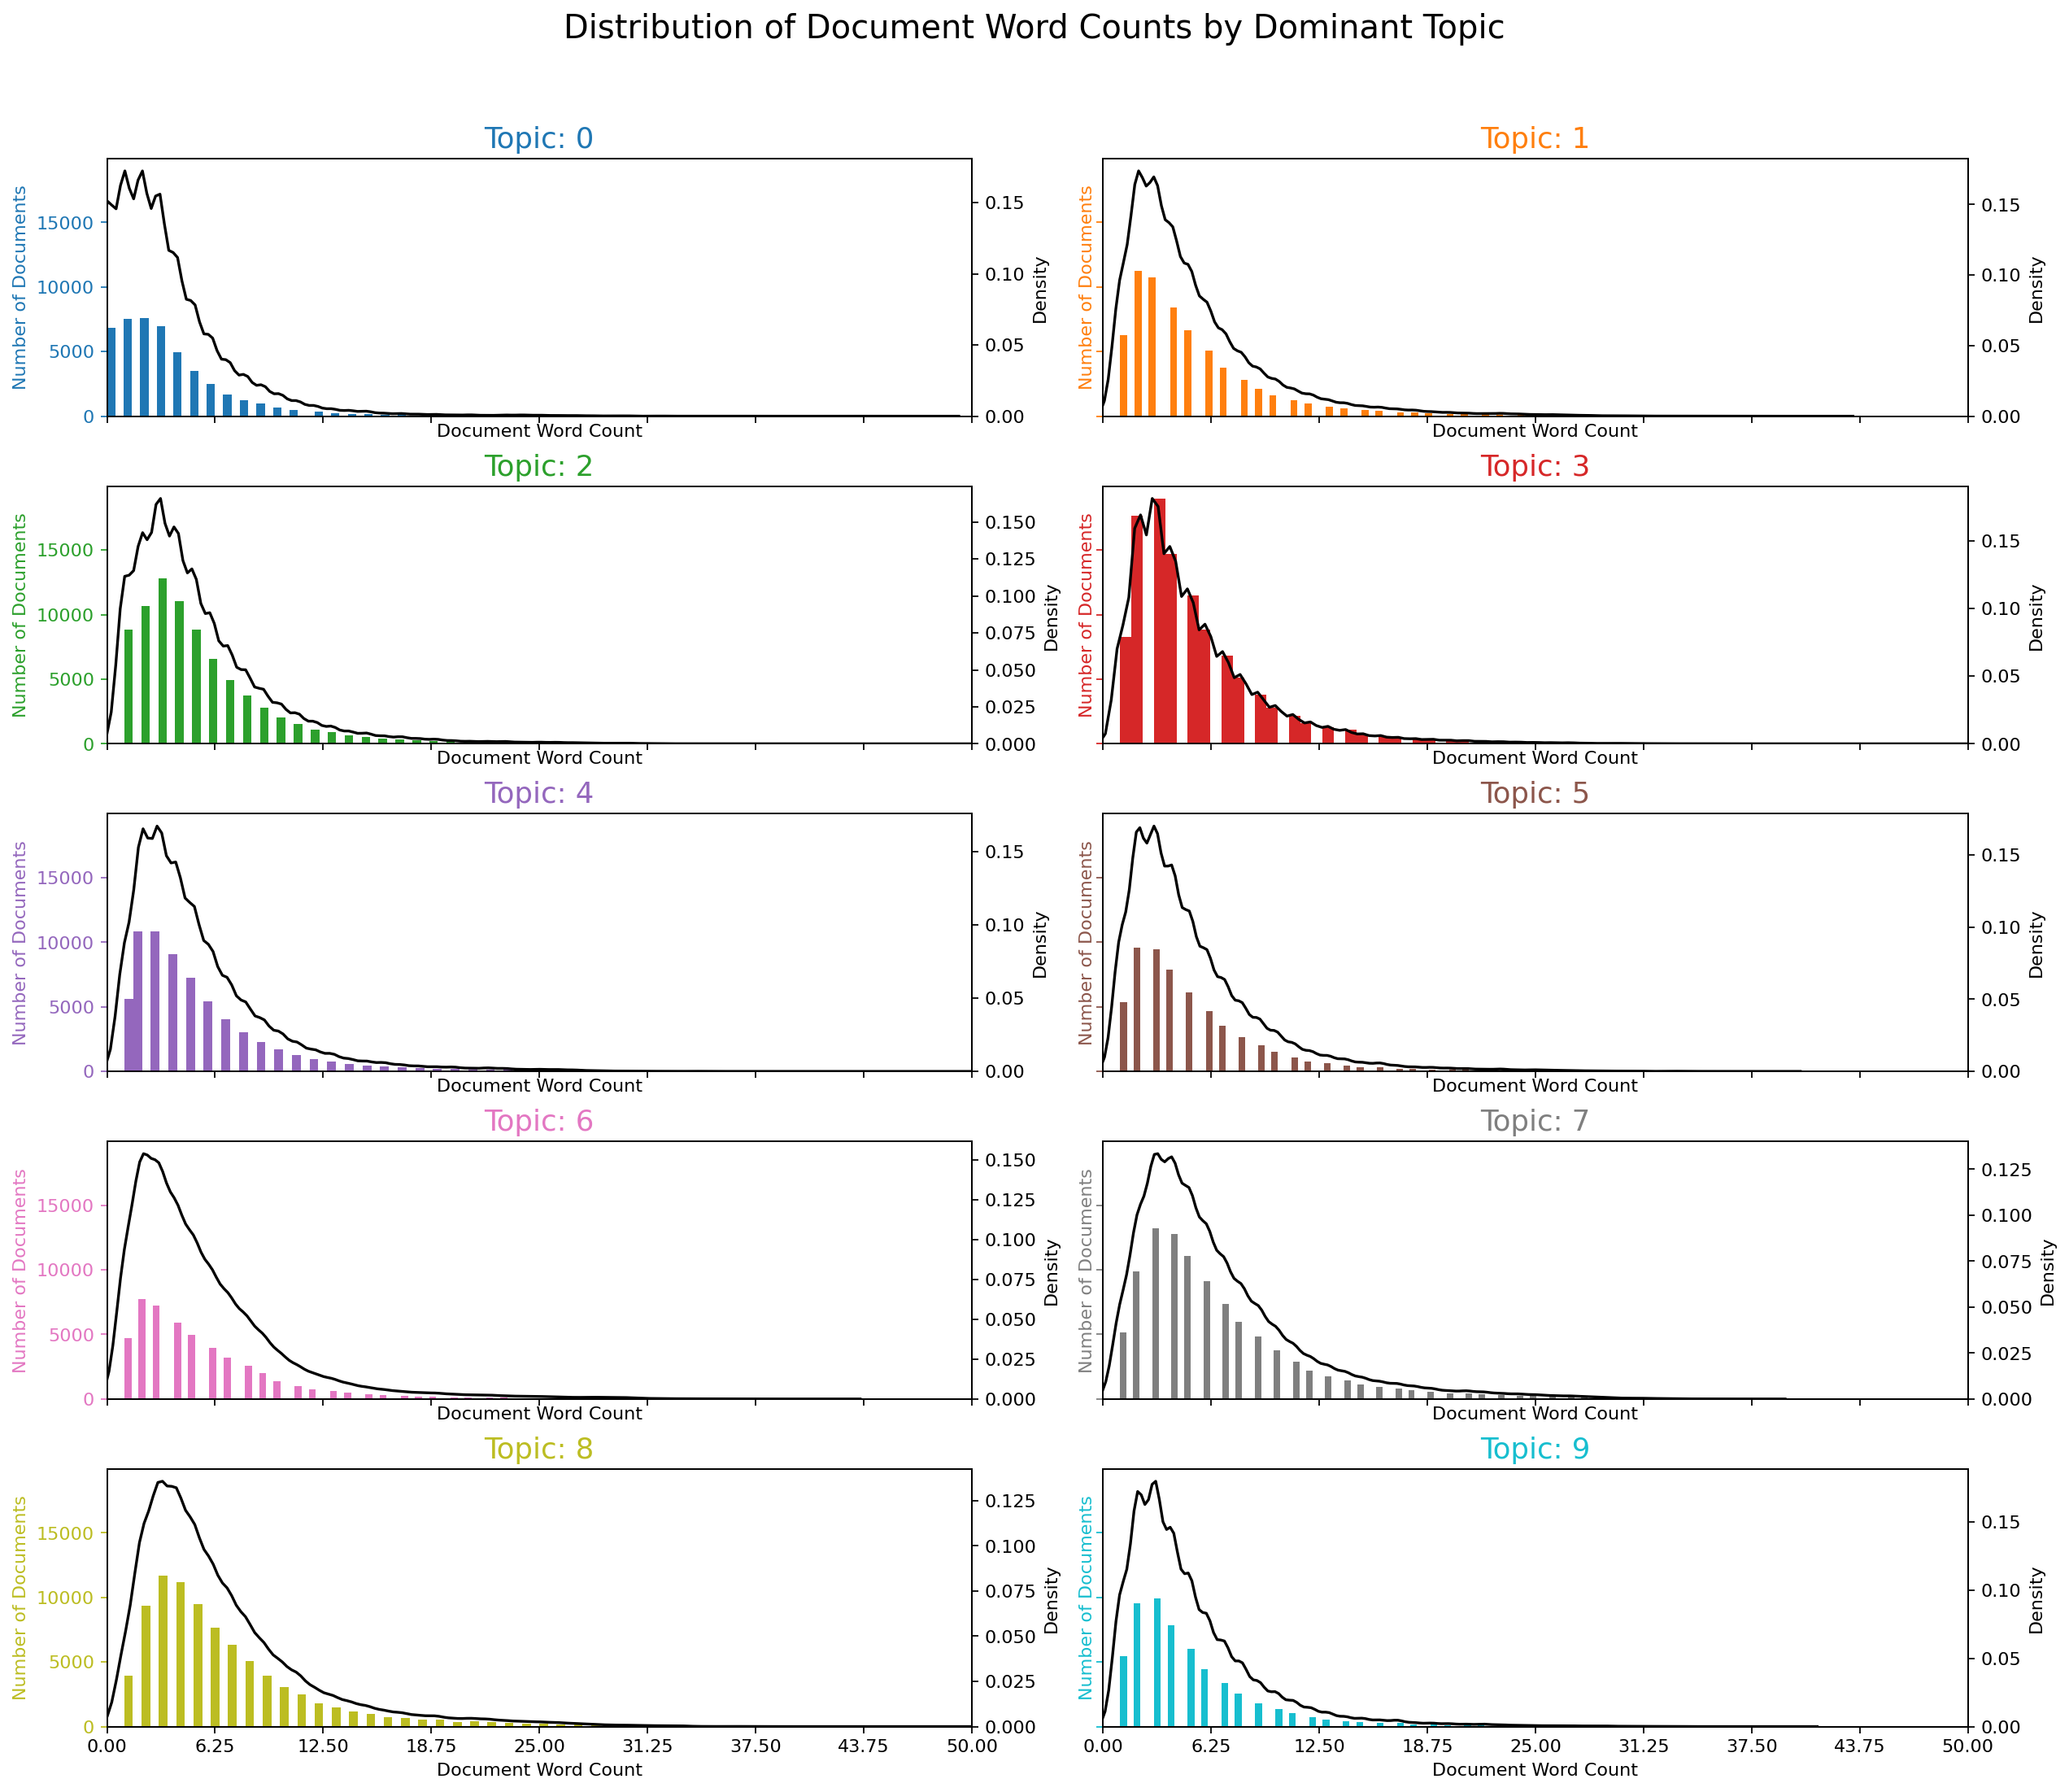

In [27]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(5,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 100, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 50), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,50,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=18)
plt.show()

## Selftext

In [9]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(df_NLP['selftext_lemmatized'])
# Create Corpus
texts = df_NLP['selftext_lemmatized']
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:2][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 3), (10, 1), (11, 1)]


In [10]:
from pprint import pprint
import gensim
# number of topics
num_topics = 10
# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.075*"gt" + 0.021*"p" + 0.019*"s" + 0.015*"click" + 0.013*"trump" + '
  '0.012*"chart" + 0.012*"sma" + 0.011*"index" + 0.010*"release" + '
  '0.010*"airline"'),
 (1,
  '0.140*"xb" + 0.061*"qflair" + 0.061*"restrictsron" + 0.050*"best" + '
  '0.042*"wwwredditcomrwallstreetbetssearch" + 0.037*"sorttop" + 0.036*"daily" '
  '+ 0.029*"weekly" + 0.025*"sortnew" + 0.021*"thread"'),
 (2,
  '0.022*"company" + 0.008*"year" + 0.007*"s" + 0.006*"business" + '
  '0.006*"market" + 0.005*"new" + 0.005*"product" + 0.004*"well" + '
  '0.004*"covid" + 0.004*"one"'),
 (3,
  '0.022*"call" + 0.021*"buy" + 0.019*"go" + 0.016*"stock" + 0.015*"price" + '
  '0.014*"sell" + 0.013*"day" + 0.012*"week" + 0.012*"share" + 0.011*"c"'),
 (4,
  '0.015*"stock" + 0.014*"market" + 0.010*"trade" + 0.009*"money" + '
  '0.008*"like" + 0.007*"people" + 0.007*"account" + 0.007*"time" + 0.006*"go" '
  '+ 0.006*"trading"'),
 (5,
  '0.032*"go" + 0.017*"shit" + 0.013*"like" + 0.011*"money" + 0.011*"u" + '
  '0.009*"retar

## Dominant topic and its percentage contribution in each document

In [11]:
df_topic_sents_keywords = format_topics_sentences(ldamodel_=lda_model, corpus_=corpus, texts_=texts)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

Document_No  ...                                               Text
0            0  ...  [cad, bb, move, gain, traction, ape, brain, mo...
1            1  ...                                                 []
2            2  ...                                                 []
3            3  ...                                                 []
4            4  ...  [bb, move, higher, patent, alone, pipeline, ho...
5            5  ...                                                 []
6            6  ...                                                 []
7            7  ...                                                 []
8            8  ...                                                 []
9            9  ...  [nerd, long, time, post, bearing, gift, knowle...

[10 rows x 5 columns]

In [12]:
df_dominant_topic.to_csv('/content/drive/MyDrive/WSB/df_dominant_topic_selftext.csv')

In [14]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100

sent_topics_sorteddf_mallet = pd.DataFrame()
sent_topics_outdf_grpd = df_dominant_topic.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Topic_Perc_Contrib'], ascending=False).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Document_No','Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

Document_No  ...                                                                                  Representative Text
0       542253  ...  [bb, bb, bb, bb, bb, bb, bb, bb, bb, bb, bb, bb, bb, bb, bb, bb, bb, bb, bb, bb, bb, bb, bb, bb,...
1       284807  ...  [daily, trading, discussion, thread, please, keep, shitposting, minimum, navigate, wsb, we, reco...
2       235318  ...  [xb, rblx, rblx, rblx, rblx, rblx, rblx, rblx, rblx, rblx, rblx, rblx, rblx, rblx, rblx, rblx, r...
3        17878  ...  [ever, one, real, indicator, stock, market, crash, always, close, bearish, monthly, candle, happ...
4       654584  ...  [text, text, text, text, text, text, text, text, text, text, text, text, text, text, text, text,...
5       618882  ...  [shit, shit, shit, shit, shit, shit, shit, shit, shit, shit, shit, shit, shit, shit, shit, shit,...
6       141960  ...  [ford, ford, ford, ford, ford, ford, ford, ford, ford, ford, ford, ford, ford, ford, ford, ford,...
7       544060  ...  [amc, amc, amc, amc, amc, amc, amc, amc, amc, amc, amc, amc, amc, amc, amc, amc, amc, amc, amc, ...
8        78220  ...  [test, test, test, testtest, test, test, testtest, test, test, testtest, test, test, testtest, t...
9        72446  ...  [wish, wish, wish, wish, wish, wish, wish, wish, wish, wish, wish, wish, wish, wish, wish, wish,...

[10 rows x 5 columns]

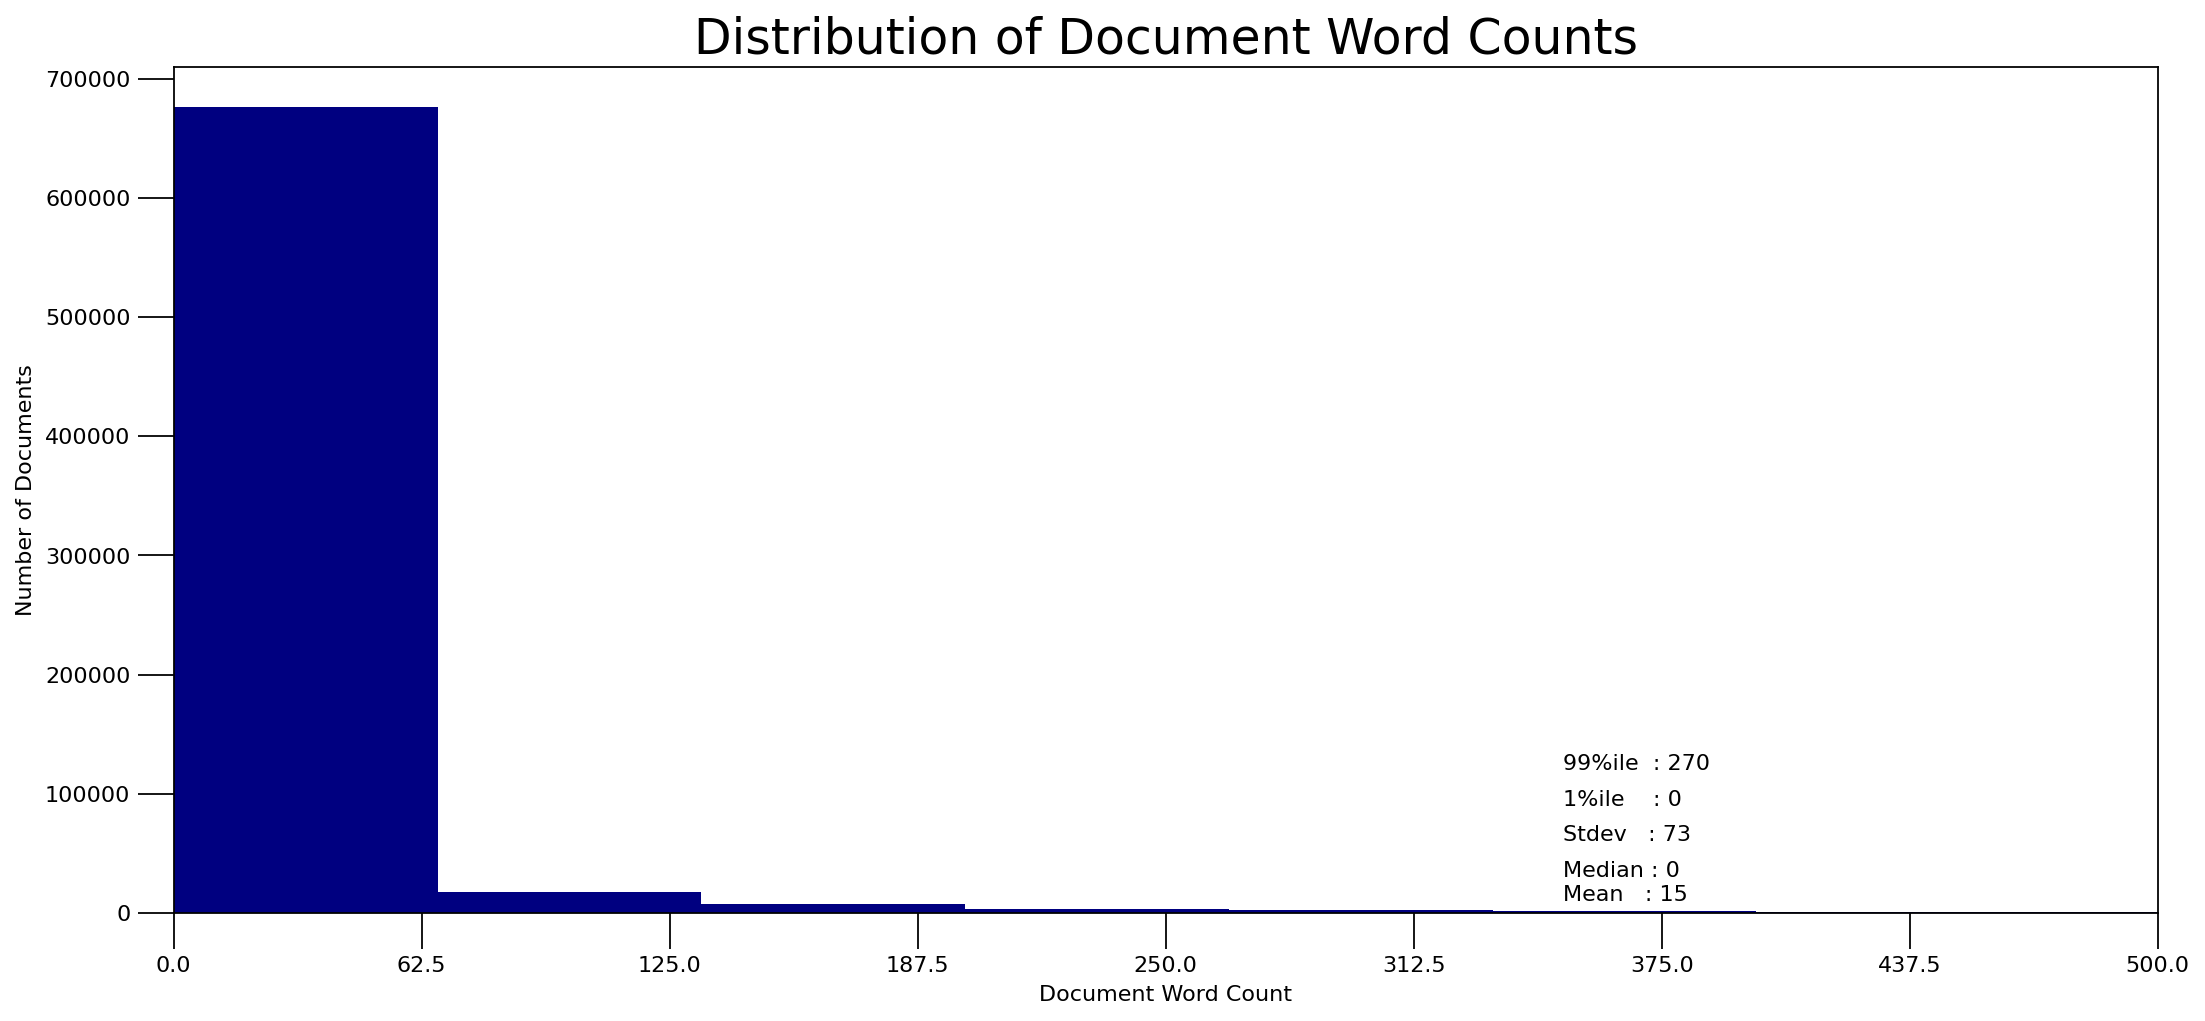

In [31]:
doc_lens = [len(d) for d in df_dominant_topic.Text]

# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 100, color='navy')
plt.text(350, 10000, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(350,  30000, "Median : " + str(round(np.median(doc_lens))))
plt.text(350,  60000, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(350,  90000, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(350,  120000, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 500), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,500,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

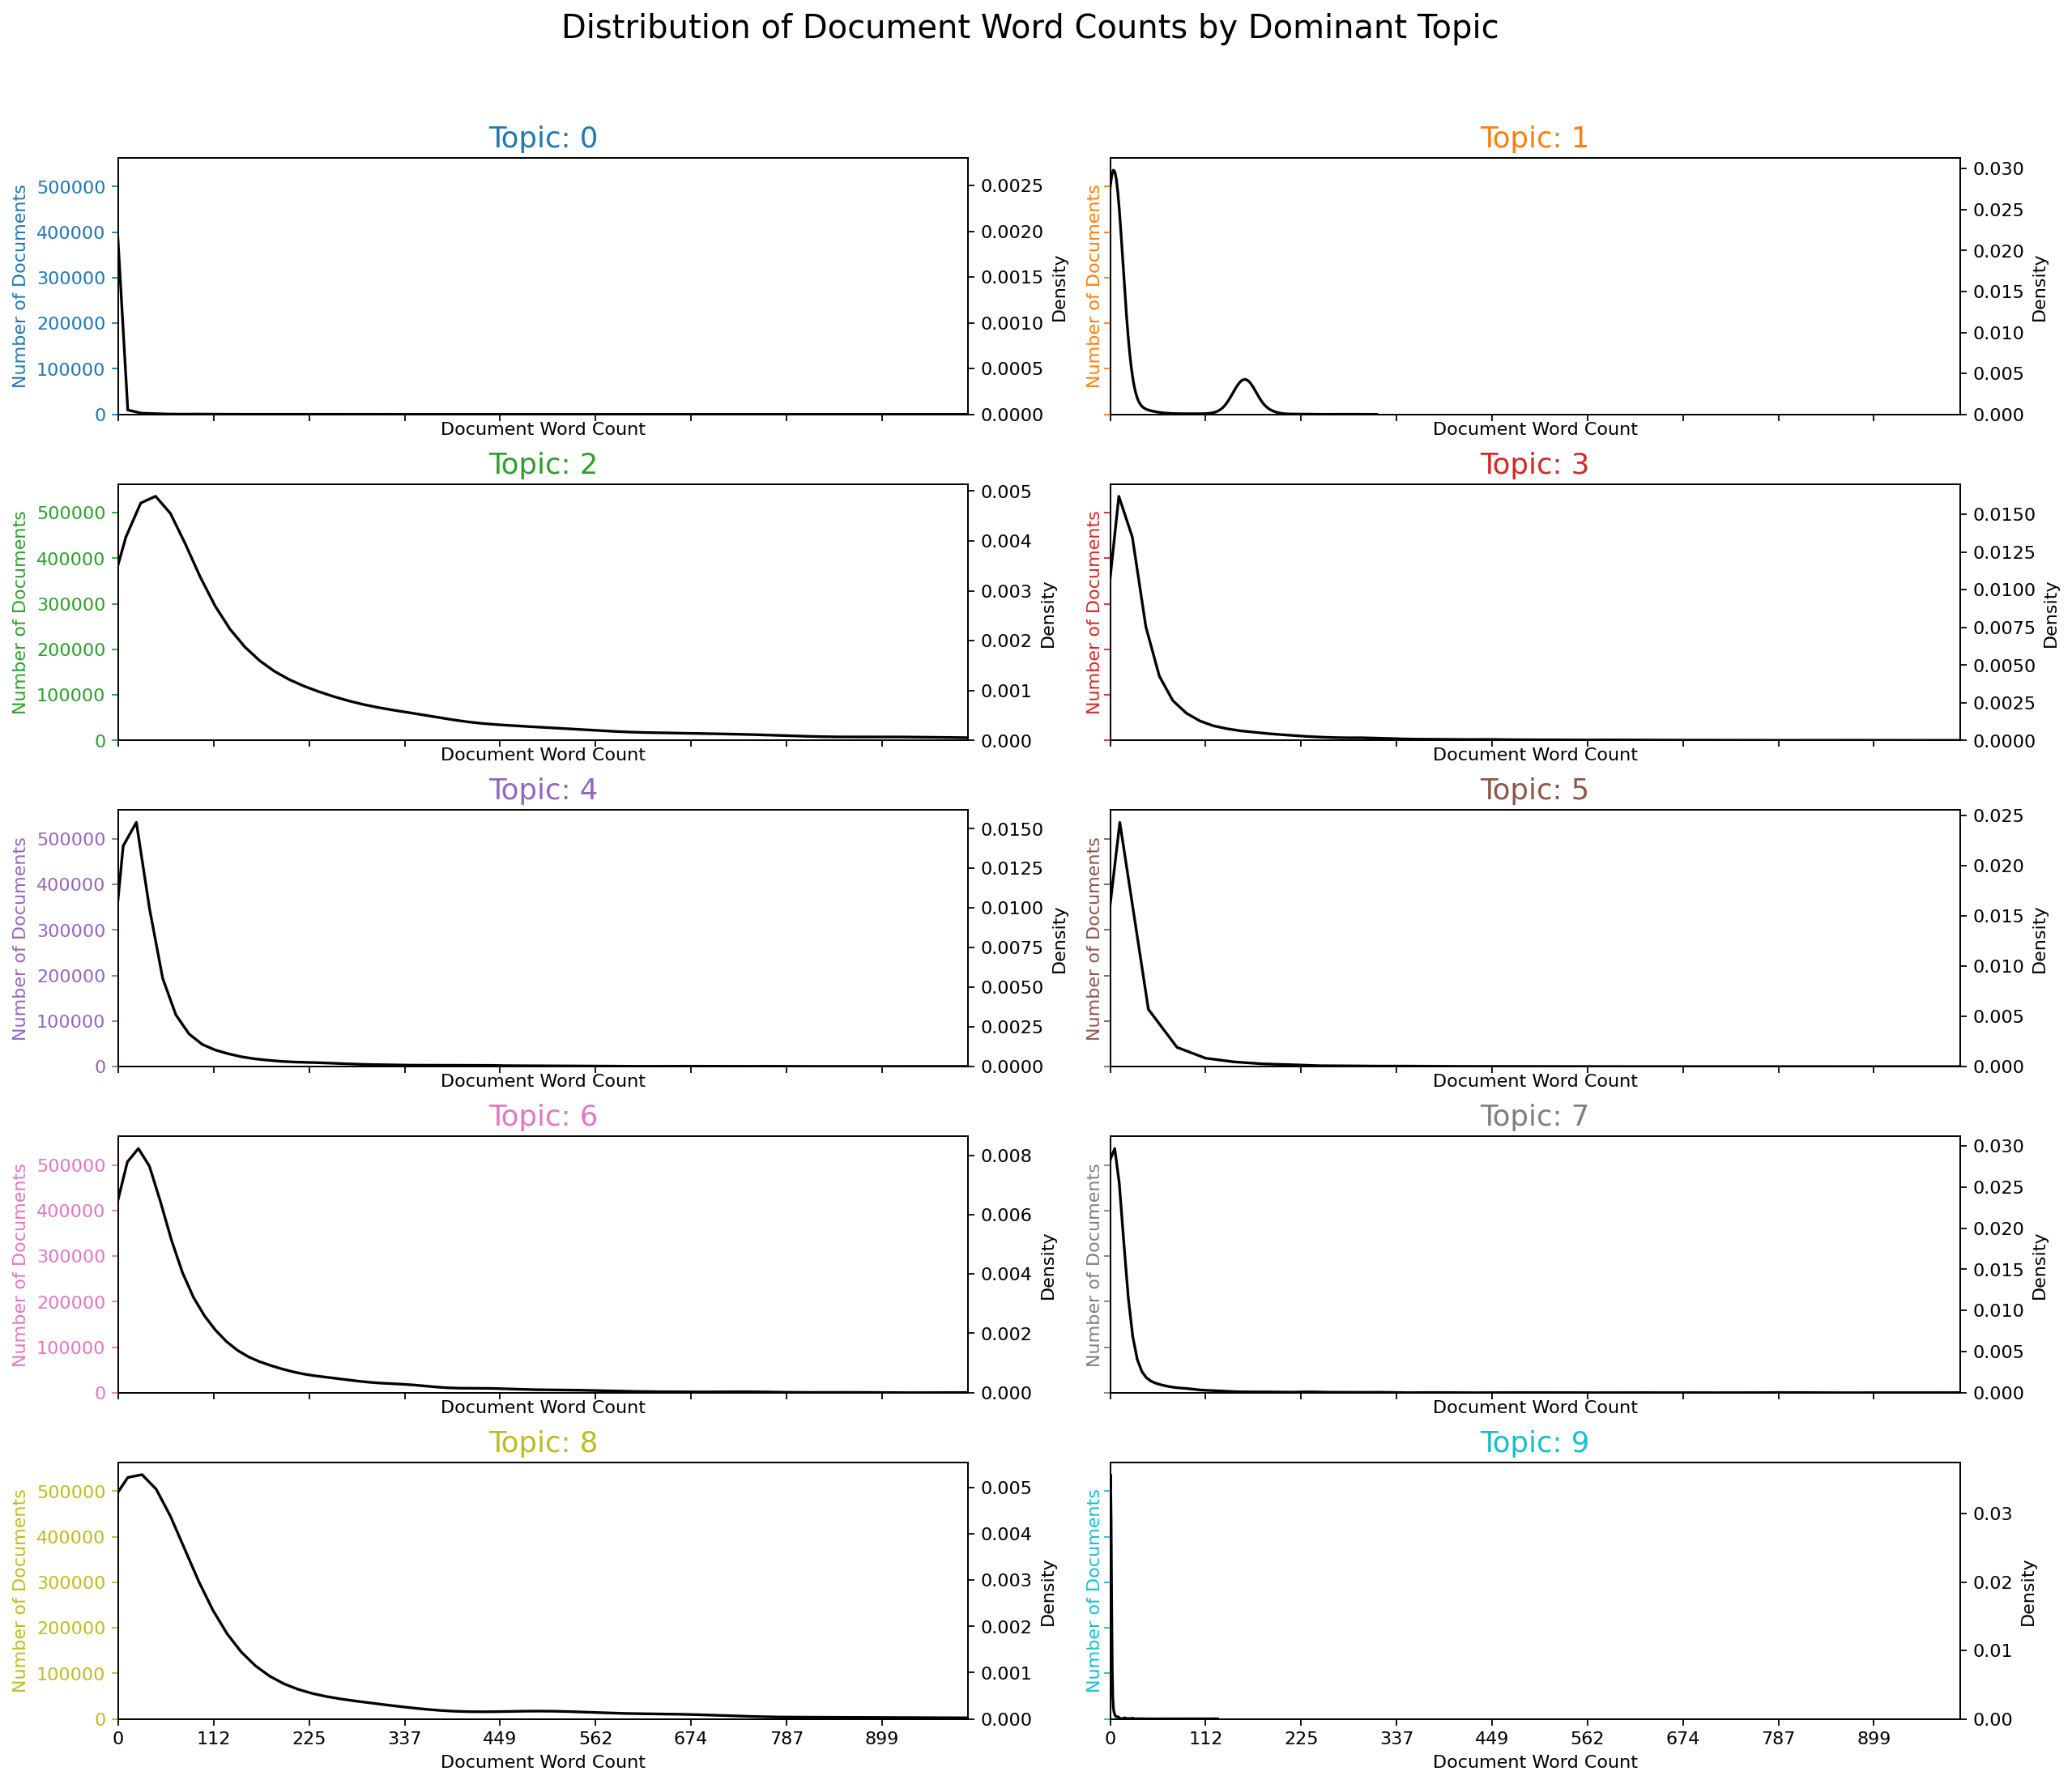

In [40]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(5,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 10000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0,1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,10000,90))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=18)
plt.show()

In [ ]:
nltk.download('stopwords')

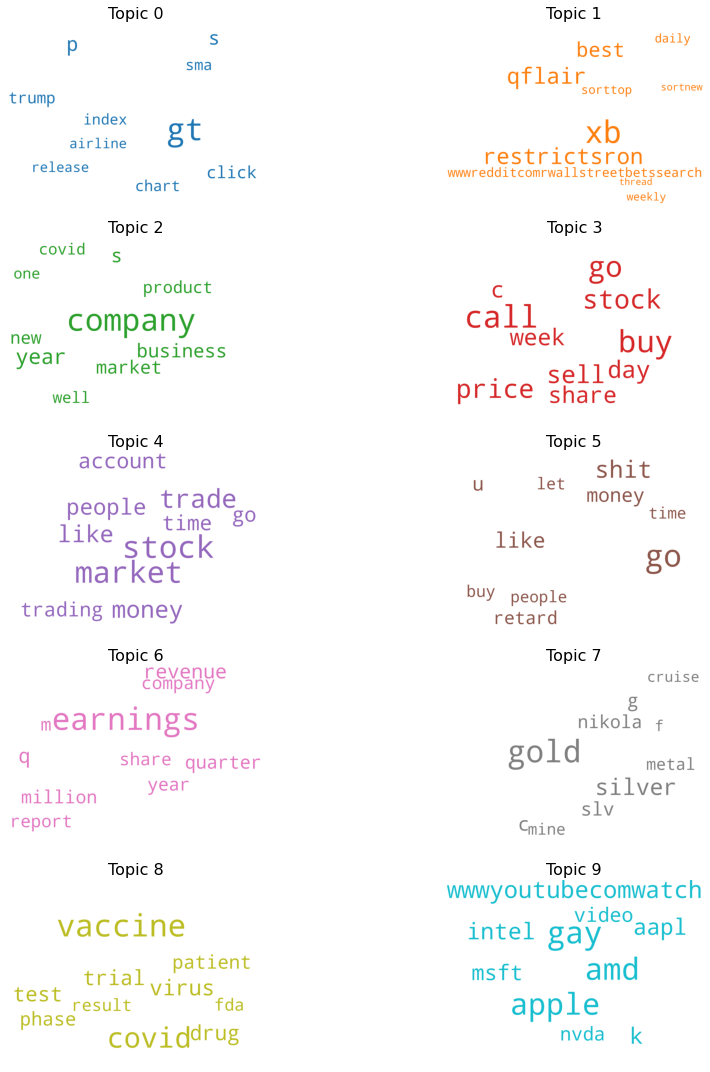

In [43]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=15,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(5, 2, figsize=(15,15), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

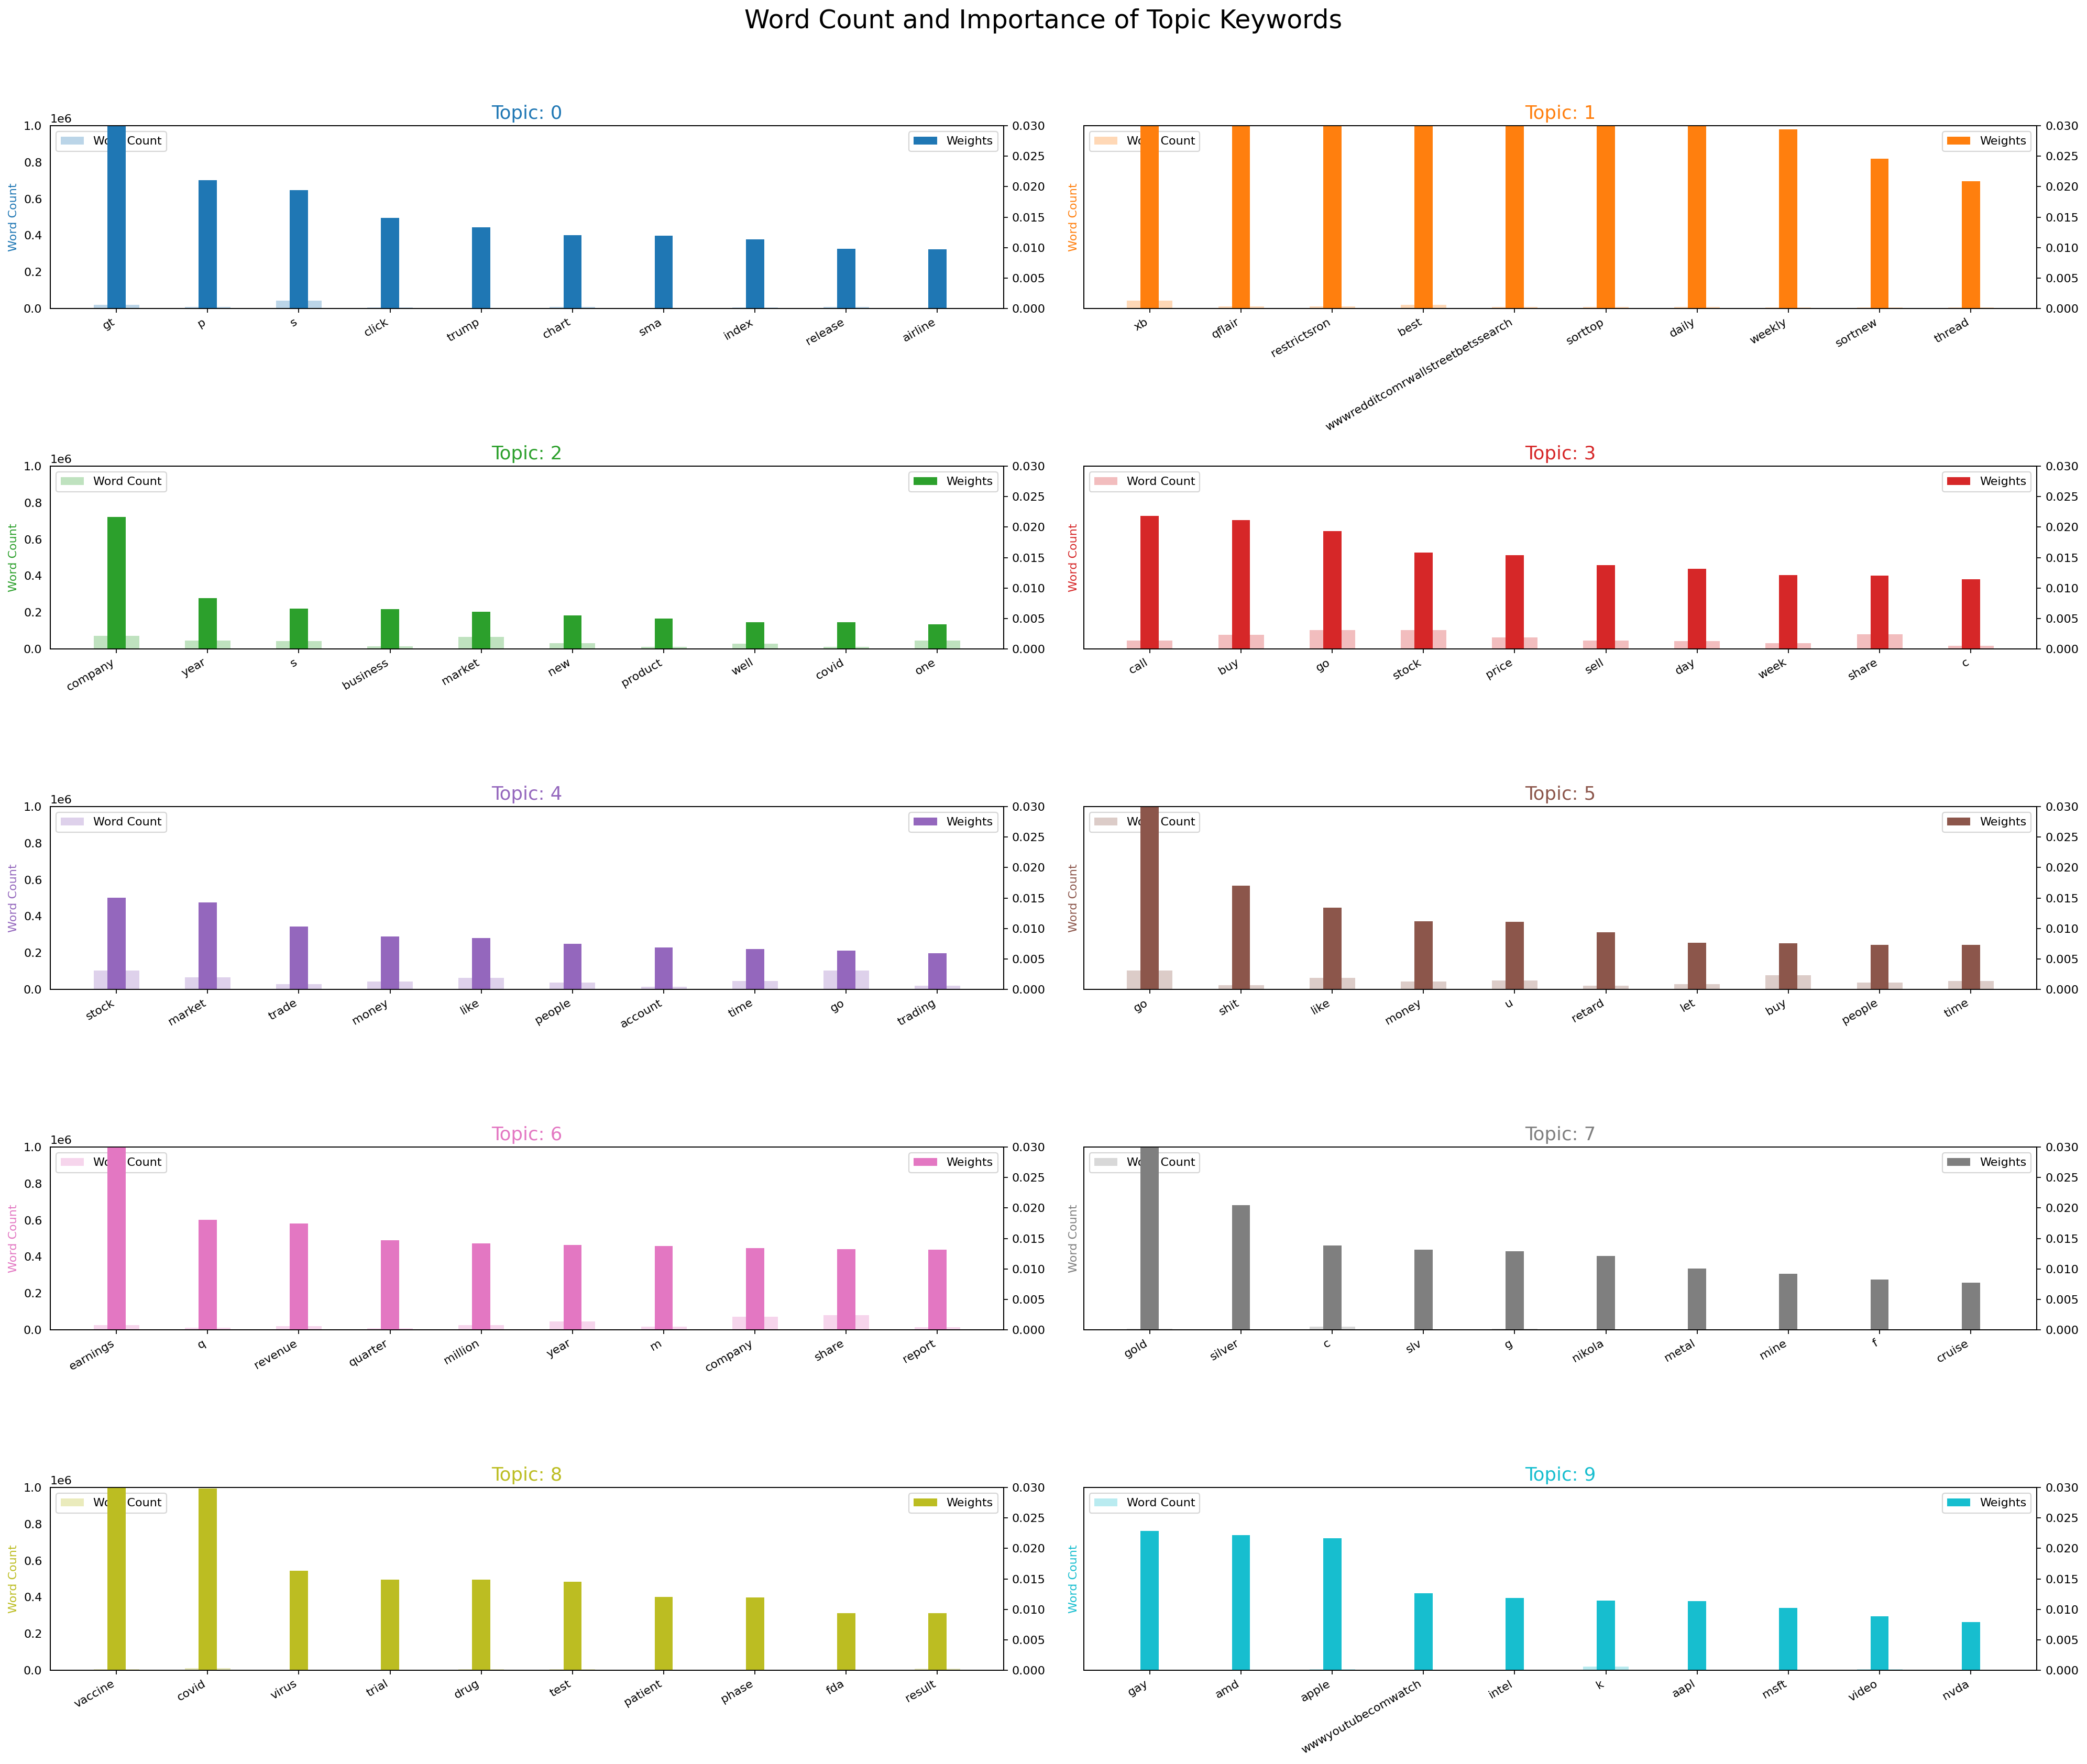

In [45]:
from collections import Counter
topics = lda_model.show_topics(formatted=False)
data_flat = [w for w_list in texts for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(5, 2, figsize=(25,20), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    ax_twin = ax.twinx()
    ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 1000000)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()

In [46]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda_model[corpus]):
    #print([w for i, w in row_list])
    #break
    topic_weights.append([w for i, w in row_list])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 10
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 162462 samples in 0.556s...
[t-SNE] Computed neighbors for 162462 samples in 20.574s...
[t-SNE] Computed conditional probabilities for sample 1000 / 162462
[t-SNE] Computed conditional probabilities for sample 2000 / 162462
[t-SNE] Computed conditional probabilities for sample 3000 / 162462
[t-SNE] Computed conditional probabilities for sample 4000 / 162462
[t-SNE] Computed conditional probabilities for sample 5000 / 162462
[t-SNE] Computed conditional probabilities for sample 6000 / 162462
[t-SNE] Computed conditional probabilities for sample 7000 / 162462
[t-SNE] Computed conditional probabilities for sample 8000 / 162462
[t-SNE] Computed conditional probabilities for sample 9000 / 162462
[t-SNE] Computed conditional probabilities for sample 10000 / 162462
[t-SNE] Computed conditional probabilities for sample 11000 / 162462
[t-SNE] Computed conditional probabilities for sample 12000 / 162462
[t-SNE] Computed conditional probab

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


[t-SNE] KL divergence after 250 iterations with early exaggeration: 96.325394
[t-SNE] KL divergence after 1000 iterations: 3.132108


In [60]:
# Sentence Coloring of N Sentences
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):    
        #print(i)
        #print(corp)
        #break
        topic_percs = model[corp]
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    return(dominant_topics, topic_percentages)

In [61]:


dominant_topics, topic_percentages = topics_per_document(model=lda_model, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda_model.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)

In [57]:
lda_model[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 3), (10, 1), (11, 1)]]

[(0, 0.14862281), (3, 0.3395642), (5, 0.38937256), (6, 0.082437545)]

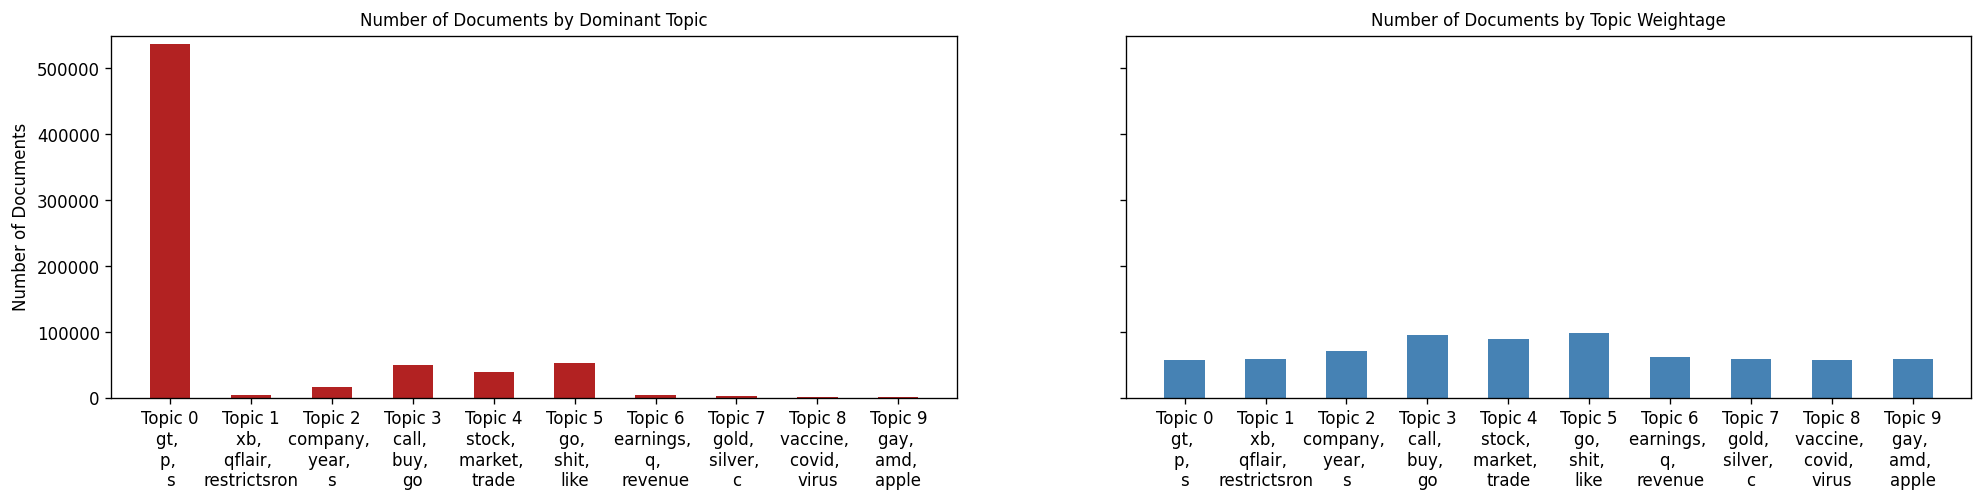

In [68]:
from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 100000)

# Topic Distribution by Topic Weights
ax2.bar(x='index', height='count', data=df_topic_weightage_by_doc, width=.5, color='steelblue')
ax2.set_xticks(range(df_topic_weightage_by_doc.index.unique().__len__()))
ax2.xaxis.set_major_formatter(tick_formatter)
ax2.set_title('Number of Documents by Topic Weightage', fontdict=dict(size=10))

plt.show()

In [ ]:
!pip install pyLDAvis

In [ ]:
import pyLDAvis.gensim_models 
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary=lda_model.id2word)
vis

## Are there differences in wording (of the title) based on the post flair?

In [ ]:
## topics group by post flair for title